# Pneumonia Classifier - VGG16

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

2023-09-27 18:40:21.607234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-27 18:40:21.607272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-27 18:40:21.607295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-27 18:40:21.613371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 18:40:22.341249: W tensorflow/compiler/

TensorFlow version: 2.14.0


In [2]:
# Check if physical GPU device detected
gpu_devices = tf.config.list_physical_devices('GPU')
if not len(gpu_devices):
    print('No GPUs detected!')
else:
    print(len(gpu_devices), 'GPUs found!')
    print(gpu_devices)

1 GPUs found!
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-09-27 18:40:22.846926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 18:40:22.869459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 18:40:22.869692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Setup Environment
dataset_base_dir = '../Dataset/chest_xray_resized/'
train_data_dir = 'train'
valid_data_dir = 'valid'
test_data_dir = 'test'
models_dir = './models'

In [4]:
# Image Data Generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

test_datagen = image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

image_shape = (224, 224, 3)
batch_size = 32

In [5]:
# Data Flow with Augmentation

train_gen = train_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, train_data_dir),
    target_size=image_shape[:2],
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, valid_data_dir), 
    target_size=image_shape[:2], 
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(dataset_base_dir, test_data_dir), 
    target_size=image_shape[:2],
    class_mode='binary', 
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# Train Dataset Stats - IMBALANCED (DUE TO MEDICAL)
from collections import Counter
counter = Counter(train_gen.classes)
print(counter.items())

dict_items([(0, 1341), (1, 3875)])


In [7]:
# Validation Dataset Stats - BALANCED
from collections import Counter
counter = Counter(valid_gen.classes)
print(counter.items())

dict_items([(0, 8), (1, 8)])


In [8]:
# Test Dataset Stats - BALANCED
from collections import Counter
counter = Counter(test_gen.classes)
print(counter.items())

dict_items([(0, 234), (1, 390)])


In [16]:
# Architect Model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False,
                         input_shape=(256,256,3),
                         weights='imagenet',
                         pooling="avg"
                        )

base_model.trainable = False
image_input = Input(shape=(256, 256, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(1,activation="sigmoid")(x)

model = Model(image_input,image_output)
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129 

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='auto')
checkpoint = ModelCheckpoint(filepath='./models/vgg16_bestcheckpoint.h5', monitor='accuracy', save_best_only=True)
# learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)

history = model.fit(train_gen, epochs=15,
          validation_data=test_gen,
          callbacks=[early_stop, checkpoint])

Epoch 1/15
163/163 [==============================] - 42s 248ms/step - loss: 0.2959 - accuracy: 0.8660 - val_loss: 0.3719 - val_accuracy: 0.8478
Epoch 2/15
163/163 [==============================] - 40s 246ms/step - loss: 0.1887 - accuracy: 0.9270 - val_loss: 0.2943 - val_accuracy: 0.8958
Epoch 3/15
163/163 [==============================] - 42s 256ms/step - loss: 0.1732 - accuracy: 0.9308 - val_loss: 0.3453 - val_accuracy: 0.8734
Epoch 4/15
163/163 [==============================] - 41s 248ms/step - loss: 0.1568 - accuracy: 0.9377 - val_loss: 0.3773 - val_accuracy: 0.8606


In [18]:
# Save trained model weights
model.save(os.path.join(models_dir, 'vgg16_pre.h5'))

In [19]:
# Evaluate the trained model
model.load_weights('./models/vgg16_bestcheckpoint.h5')
eval_results = model.evaluate(test_gen)

20/20 [==============================] - 4s 213ms/step - loss: 0.3901 - accuracy: 0.8686


In [20]:
# List the classes
test_gen.class_indices

{'normal': 0, 'pneumonia': 1}

In [21]:
# Take predictions using test image generator
test_dataset_prediction_probabilities = model.predict(test_gen)

20/20 [==============================] - 4s 214ms/step


In [22]:
# Argmax of Probabilities
test_dataset_predictions = [i > 0.5 for i in test_dataset_prediction_probabilities]
print(test_dataset_predictions)

[array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([ True]), array([ True]), array([False]), array([False]), array([ True]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([False]), array([ True]), array([

In [23]:
# Generate classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_gen.classes,test_dataset_predictions))

              precision    recall  f1-score   support

           0       0.96      0.68      0.79       234
           1       0.83      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



array([[158,  76],
       [  7, 383]])

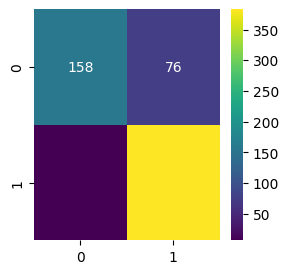

In [24]:
# Generate confusion matrix
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(test_gen.classes,test_dataset_predictions),annot = True, fmt = "d", cmap = "viridis")
confusion_matrix(test_gen.classes,test_dataset_predictions)

In [ ]:
# Manual Testing - Normal
from tensorflow.keras.preprocessing import image
normal_image = image.load_img('../Dataset/final/test/normal/0103fadb-1663-40a6-8a9e-09d626cd2091.png', target_size=image_shape[:2])
normal_image = np.expand_dims(normal_image, axis=1)
normal_image = normal_image.reshape(image_shape)
normal_image = normal_image / 256
plt.imshow(normal_image)
prediction = model.predict(normal_image.reshape(1, 224, 224, 3))
print(prediction[0][0] > 0.5)

In [ ]:
# Manual Testing - Pneumonia
from tensorflow.keras.preprocessing import image
positive_image = image.load_img('../Dataset/final/test/pneumonia/MIDRC-RICORD-1C-419639-000025-17477-0.png', target_size=image_shape[:2])
positive_image = np.expand_dims(positive_image, axis=1)
positive_image = positive_image.reshape(image_shape)
positive_image = positive_image / 256
plt.imshow(positive_image)
prediction = model.predict(positive_image.reshape(1, 224, 224, 3))
print(prediction[0][0] > 0.5)